<a href="https://colab.research.google.com/github/RishabhL7/Model_Comparison/blob/main/FYHGS_HGR_NET_DataAugmentation_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm

In [3]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

#READING THE IMAGE AND LABEL FOR FINAL RECOGNITION

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
!unzip '/content/drive/MyDrive/Dataset.zip'

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: Complete/
  inflating: Complete/A-1.jpg        
  inflating: Complete/A-10.jpg       
  inflating: Complete/A-100.jpg      
  inflating: Complete/A-11.jpg       
  inflating: Complete/A-12.jpg       
  inflating: Complete/A-13.jpg       
  inflating: Complete/A-14.jpg       
  inflating: Complete/A-15.jpg       
  inflating: Complete/A-16.jpg       
  inflating: Complete/A-17.jpg       
  inflating: Complete/A-18.jpg       
  inflating: Complete/A-19.jpg       
  inflating: Complete/A-2.jpg        
  inflating: Complete/A-20.jpg       
  inflating: Complete/A-21.jpg       
  inflating: Complete/A-22.jpg       
  inflating: Complete/A-23.jpg       
  inflating: Complete/A-24.jpg       
  inflating: Complete/A-25.jpg       
  inflating: Complete/A-26.jpg       
  inflating: Complete/A-27.jpg       
  inflating: Complete/A-28.jpg       
  inflating: Complete/A-29.jpg       
  inflating: Complete/A-3.jpg        
  inflating: Complet

In [6]:
path = "/content/Complete"

x_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_train = []
print('creating train data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_train.append(tails[0])
    n+=1

creating train data for recognition ( Only color images and respective labels)


100%|██████████| 1000/1000 [03:04<00:00,  5.42it/s]


#SEGMENTATION MODEL

In [14]:
#Import necessary libraries

import keras

import tensorflow as tf
from keras.datasets import mnist

from keras.models import Model,Input

from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

In [15]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

In [16]:
# LATEST MODEL - LINKNET only

def ASPP(inputs):

    conv_filters = 64
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y
def sa_block(inputs):
    """
    Spatial Attention Module utilizing the inter-spatial relationship of features.
    """
    kernel_size = 3

    # avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    # max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)
    avg_pool = K.mean(inputs, axis=-1, keepdims=True)
    max_pool = K.max(inputs, axis=-1, keepdims=True)

    x = Concatenate()([avg_pool, max_pool])

    x = Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)

    outputs = Multiply()([inputs, x])
    return outputs

def build_LinkNet_mobilenetv2():    
  model = tf.keras.applications.MobileNetV2(input_shape=(320, 320,3), include_top=False, weights="imagenet")

  """ Skip Connections """

  s1 = model.get_layer("block_1_expand_relu").output         ## (160, 160)
  #s1 = sa_block(s1)
  s2 = model.get_layer("block_3_expand_relu").output         ## ( 80, 80)
  #s2 = sa_block(s2)
  s3 = model.get_layer("block_6_expand_relu").output         ## (40, 40)
  #s3 = sa_block(s3)
  s4 = model.get_layer("block_13_expand_relu").output         ## (20, 20)
  #s4 = sa_block(s4)
  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("out_relu").output
  b1 = ASPP(b1)
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(320, (1,1), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(320, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(576, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(144, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(192, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(48, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(48, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(36, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(36, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(96, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(24, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(24, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  x = Dropout(0.15)(x)
  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

#RECOGNITION MODEL

In [17]:
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, Conv2D, Input,merge,AveragePooling2D,concatenate
from keras.models import Model

In [18]:
# Recognition Model

class RecModel(object):
        def __init__(self, input_size,num_class):
            self.input_size=input_size
            self.num_class=num_class

            self._build_model()

        def _build_model(self):
                Smodel=build_LinkNet_mobilenetv2()
                checkpoint_path_segmentUNET = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/mobv2link_aspp_500/cp.ckpt"
                Smodel.load_weights(checkpoint_path_segmentUNET)
                l=len(Smodel.layers)
                for layer in Smodel.layers[:l]:
                    layer.trainable = False

                inp = Input(shape=self.input_size)
                inp_stream1=Smodel.input
                inp_stram2 = Smodel.output

                ###Stream1------------------

                x = Conv2D(16, 3, activation = 'relu', padding = 'same' ,dilation_rate=1,name='CV1')(inp_stream1)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(32, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV2')(x)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(64, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV4')(x)
                x = MaxPooling2D(pool_size=(3, 3))(x)

                x = Conv2D(128, 3, activation = 'relu', padding = 'same',dilation_rate=3,name='CV41')(x)
                xf1 = MaxPooling2D(pool_size=(3, 3))(x)
              
                ###Stream2--------------------

                x1 = Conv2D(16, 3, activation = 'relu', padding = 'same',dilation_rate=1,name='CV11')(inp_stram2)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(32, 3, activation = 'relu', padding = 'same',dilation_rate=2,name='CV421')(x1)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(64, 3, activation = 'relu', padding = 'same',dilation_rate=2 ,name='CV31')(x1)
                x1 = MaxPooling2D(pool_size=(3, 3))(x1)

                x1 = Conv2D(128, 3, activation = 'relu', padding = 'same',dilation_rate=3,name='CV412')(x1)
                xf2 = MaxPooling2D(pool_size=(3, 3))(x1)

                ####--------
                f = keras.layers.concatenate([xf1,xf2], axis = 3) 
                f = MaxPooling2D(pool_size=(3, 3))(f)


                f = Flatten()(f)

                f = Dropout(0.2)(f)

                prediction = Dense(self.num_class, activation="softmax")(f)
                model_final = Model(Smodel.input, prediction)
                                                    


                self.model_F=model_final

In [19]:
input_size = (320,320,3)
num_class = 10
RecM=RecModel((320,320,3), 10)
model=RecM.model_F
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                             

In [20]:
#Our CNN model
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

# **WITHOUT DATA AUGMENTATION**

Check if the model gives any value of accuracy without fitting it first


In [18]:
_adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    decay=0.0
)
model.compile(loss='binary_crossentropy',optimizer = _adam,metrics=['accuracy'])


In [19]:
y_debug_pred = model.predict(x_train)

In [20]:
np.argmax(y_debug_pred[0])

9

In [21]:
model.evaluate(x_train, y_train)

32/32 [==============================] - 8s 137ms/step - loss: 3.4118 - accuracy: 0.1000


[3.411794900894165, 0.10000000149011612]

Model predict is giving a value
NOW WE FIT THE DATA

In [22]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData"
os.mkdir(path)

In [23]:
#Model Checkpoint
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/cp.ckpt"
model_checkpoint_recog_augmentation = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog_augmentation,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [25]:
history = model.fit(x_train, y_train, batch_size=2, epochs=50,validation_split=0.1, callbacks=[model_checkpoint_recog_augmentation])

Epoch 1/50
448/450 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.6116
Epoch 1: val_accuracy improved from -inf to 0.98000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/cp.ckpt
450/450 [==============================] - 24s 29ms/step - loss: 0.2497 - accuracy: 0.6122 - val_loss: 0.0370 - val_accuracy: 0.9800
Epoch 2/50
449/450 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9800
Epoch 2: val_accuracy improved from 0.98000 to 1.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/cp.ckpt
450/450 [==============================] - 12s 27ms/step - loss: 0.0323 - accuracy: 0.9800 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 3/50
449/450 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9900
Epoch 3: val_accuracy did not improve from 1.00000
450/450 [==============================] - 11s 25ms/step - loss: 0.0161 - accuracy: 0.9900 - val_loss:

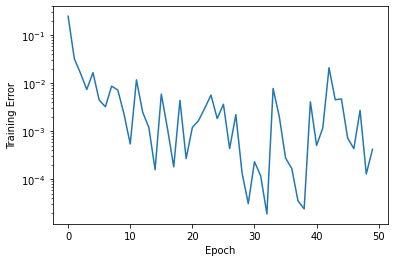

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_UNAUGMENTED.png')

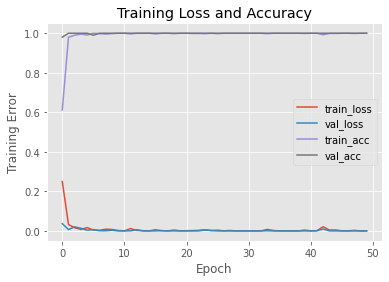

In [44]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_RECOGNITION_Unaugmented.png')

In [ ]:
model.load_weights(checkpoint_path_recog)

TEST DATA

In [ ]:
path = "/content/OUHANDS_Siddhant/testing/colour"

x_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_test = []
print('creating test data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_test.append(tails[0])
    n+=1

creating test data for recognition ( Only color images and respective labels)


100%|██████████| 1000/1000 [00:10<00:00, 94.66it/s]


In [ ]:
y_test

In [ ]:
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(1000, 320, 320, 3)
(1000,)


EVALUATION ( **WITHOUT AUGMENTATION** )

Evaluation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
 #    ######evaluate#####
checkpoint_path_recog = "/content/drive/MyDrive/chekpRecog_UNET/cpr.ckpt"
model.load_weights(checkpoint_path_recog)




In [ ]:
y_pred=model.predict(x_test)

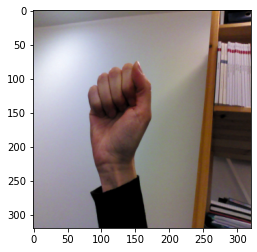

In [ ]:
plt.imshow(array_to_img(x_test[5]))

In [ ]:
y_classes = [np.argmax(i) for i in y_pred]

In [ ]:
y_classes[:5]

[3, 9, 9, 0, 6]

In [ ]:
y_test[:5]

array([7, 2, 6, 0, 6])

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       100
           1       0.86      0.88      0.87       100
           2       0.69      0.71      0.70       100
           3       0.68      0.75      0.71       100
           4       0.90      0.64      0.75       100
           5       0.80      0.65      0.72       100
           6       0.70      0.71      0.71       100
           7       0.86      0.59      0.70       100
           8       0.72      0.87      0.79       100
           9       0.58      0.86      0.69       100

    accuracy                           0.75      1000
   macro avg       0.77      0.75      0.75      1000
weighted avg       0.77      0.75      0.75      1000



Text(69.0, 0.5, 'Truth')

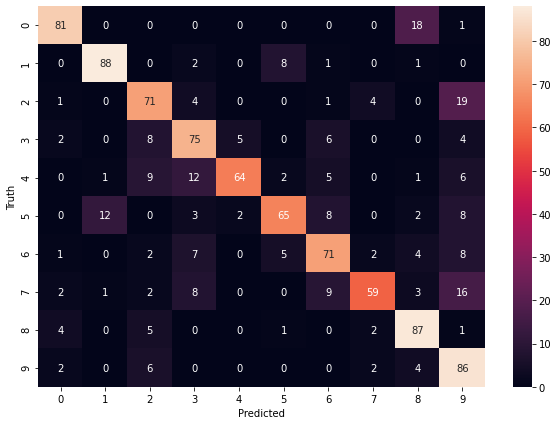

In [ ]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print("F1-Score", f1_score(y_test, y_classes, average='macro'))

F1-Score 0.7474207942926328


**F1 Score  ( Without Data Augmentation ) - 0.7550160647774412**

#**DATA AUGMENTATION**



In [7]:
#Train-validation-test split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.5)

In [8]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)

In [9]:
y_val = le.fit_transform(y_val)

In [10]:
y_val.shape

(500,)

In [11]:
x_val.shape

(500, 320, 320, 3)

In [12]:
#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=40, shear_range=0.2, zoom_range=0.2, horizontal_flip=False, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')

val_generator = ImageDataGenerator(rotation_range=40, shear_range=0.2, zoom_range=0.2, horizontal_flip=False, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')


#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)


Model

In [21]:
_adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    decay=0.0
)
model.compile(loss='binary_crossentropy',optimizer = _adam,metrics=['accuracy'])

In [22]:
y_train=to_categorical(y_train)
y_val = to_categorical(y_val)

xtrain_shape (500, 320, 320, 3)
y_train_shape (500, 10)


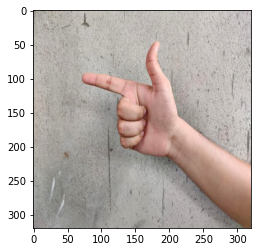

In [23]:
plt.imshow(array_to_img(x_train[0]))
print("xtrain_shape", x_train.shape)
print("y_train_shape",y_train.shape)
#print("xval shape", x_val.shape)
#print("yval shape", y_val.shape)

In [24]:
y_train[0]


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [25]:
y_val.shape

(500, 10)

Training

In [26]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4"
os.mkdir(path)

In [27]:
#Model Checkpoint
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4/cp.ckpt"
model_checkpoint_recog_augmentation = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog_augmentation,
                                                 save_weights_only=True,
                                                  monitor='accuracy',save_best_only=True,
                                                 verbose=1)

In [28]:
#Training the model
history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=2), 
                      epochs = 30, steps_per_epoch = x_train.shape[0]//2, 
                      validation_data = val_generator.flow(x_val, y_val, batch_size=2), 
                      validation_steps = 250, callbacks = [model_checkpoint_recog_augmentation], verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
249/250 [============================>.] - ETA: 0s - loss: 0.6008 - accuracy: 0.1245
Epoch 1: accuracy improved from -inf to 0.12600, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4/cp.ckpt
250/250 [==============================] - 44s 112ms/step - loss: 0.5995 - accuracy: 0.1260 - val_loss: 0.3182 - val_accuracy: 0.1860
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.3060
Epoch 2: accuracy improved from 0.12600 to 0.30600, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4/cp.ckpt
250/250 [==============================] - 25s 101ms/step - loss: 0.2850 - accuracy: 0.3060 - val_loss: 0.2325 - val_accuracy: 0.5080
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.5580
Epoch 3: accuracy improved from 0.30600 to 0.55800, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4/cp.ckpt
250/25

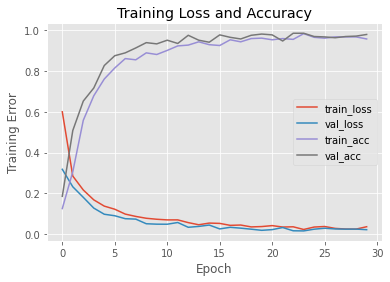

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 30
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_RECOGNITION_Augmented.png')

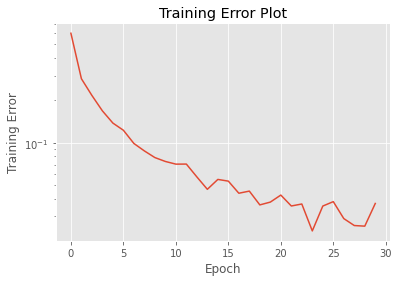

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(history.history['loss']).plot(logy=True)
plt.title("Training Error Plot")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_AUGMENTED.png')

#Useless

50 - 100 epochs

In [ ]:
model.load_weights(checkpoint_path_recog_augmentation)

In [ ]:
h2 = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=2), 
                      epochs = 50, steps_per_epoch = x_train.shape[0]//2, 
                      validation_data = val_generator.flow(x_val, y_val, batch_size=2), 
                      validation_steps = 250, callbacks = [model_checkpoint_recog_augmentation], verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
700/700 [==============================] - 77s 109ms/step - loss: 0.0494 - accuracy: 0.9207 - val_loss: 0.0364 - val_accuracy: 0.9480

Epoch 00001: val_accuracy improved from 0.93200 to 0.94800, saving model to /content/drive/MyDrive/UNET/RecognitonV2/cpr.ckpt
Epoch 2/50
700/700 [==============================] - 76s 109ms/step - loss: 0.0469 - accuracy: 0.9200 - val_loss: 0.0403 - val_accuracy: 0.9320

Epoch 00002: val_accuracy did not improve from 0.94800
Epoch 3/50
700/700 [==============================] - 76s 109ms/step - loss: 0.0481 - accuracy: 0.9236 - val_loss: 0.0488 - val_accuracy: 0.9260

Epoch 00003: val_accuracy did not improve from 0.94800
Epoch 4/50
700/700 [==============================] - 76s 109ms/step - loss: 0.0451 - accuracy: 0.9257 - val_loss: 0.0447 - val_accuracy: 0.9280

Epoch 00004: val_accuracy did not improve from 0.94800
Epoch 5/50
700/700 [==============================] - 76s 109ms/step - loss: 0.0477 - accuracy: 0.9300 - val_loss: 0.0509 - v

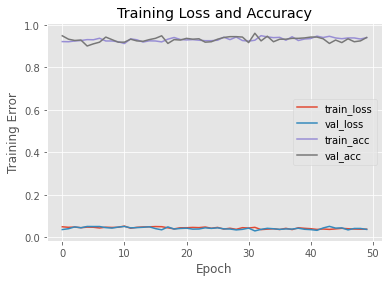

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), h2.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.savefig('UNET_Traininerrorplot_RECOGNITION_Augmented_50-100epochs.png')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/FY_HGR/01/cpr.ckpt"
model.load_weights(checkpoint_path_recog_augmentation)

In [ ]:
y_pred=model.predict(x_test)


In [ ]:
y_classes = [np.argmax(i) for i in y_pred]

In [ ]:
classes_cats = ["A", "B","C","D","E","F","H","I","J","K"]

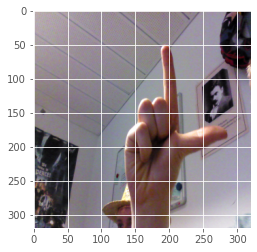

In [ ]:
plt.imshow(x_test[1])

In [ ]:
classes_cats[y_classes[1]]

'D'

In [ ]:
x_test_single = np.expand_dims(x_test[10], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.929004430770874 seconds ---


##Evaluation at the end of 50 epochs

In [ ]:
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/FY_HGR/01/cpr.ckpt"
model.load_weights(checkpoint_path_recog_augmentation)

In [ ]:
y_pred=model.predict(x_test)


In [ ]:
y_classes = [np.argmax(i) for i in y_pred]

In [ ]:
print("Classification Report at 50 epochs: \n", classification_report(y_test, y_classes))

Classification Report at 50 epochs: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       100
           1       0.94      1.00      0.97       100
           2       0.97      0.92      0.94       100
           3       0.98      0.89      0.93       100
           4       0.92      0.98      0.95       100
           5       0.96      0.92      0.94       100
           6       0.93      0.91      0.92       100
           7       0.92      0.95      0.94       100
           8       0.97      0.90      0.93       100
           9       0.91      0.96      0.93       100

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [ ]:
import pandas
report = classification_report(y_test, y_classes, output_dict=True)
df = pandas.DataFrame(report).transpose()


In [ ]:
print("F1-Score at the end of 50 epochs", f1_score(y_test, y_classes, average='macro'))

F1-Score at the end of 50 epochs 0.9427340142386852


Text(69.0, 0.5, 'Truth')

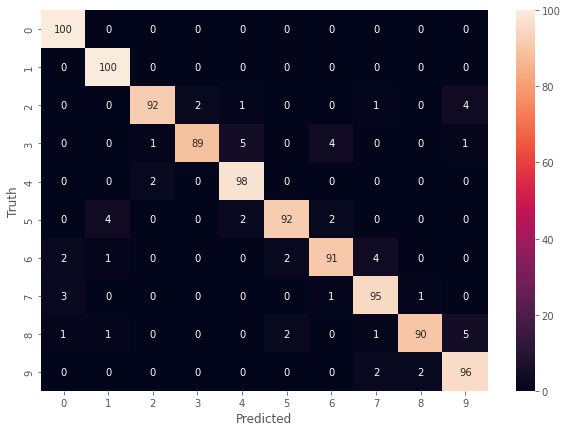

In [ ]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##EVALUATION at the end of 100 epochs

In [ ]:
checkpoint_path_recog_augmentation = "/content/drive/MyDrive/UNET/RecognitonV2/cpr.ckpt"
model.load_weights(checkpoint_path_recog_augmentation)

In [ ]:
x_test_single = np.expand_dims(x_test[100], axis = 0)

In [ ]:
import time
start_time = time.time()
y_singel = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.09890937805175781 seconds ---


In [ ]:
y_pred=model.predict(x_test)
y_classes = [np.argmax(i) for i in y_pred]

In [ ]:
print("Classification Report at 100 epochs: \n", classification_report(y_test, y_classes))

Classification Report at 100 epochs: 
               precision    recall  f1-score   support

           0       0.90      0.91      0.91       100
           1       0.91      0.96      0.94       100
           2       0.88      0.92      0.90       100
           3       0.89      0.87      0.88       100
           4       0.88      0.84      0.86       100
           5       0.83      0.77      0.80       100
           6       0.77      0.86      0.82       100
           7       0.91      0.70      0.79       100
           8       0.68      0.79      0.73       100
           9       0.96      0.93      0.94       100

    accuracy                           0.85      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.85      0.86      1000



In [ ]:
print("F1-Score at the end of 100 epochs", f1_score(y_test, y_classes, average='macro'))

F1-Score at the end of 100 epochs 0.8551876539731185


Text(69.0, 0.5, 'Truth')

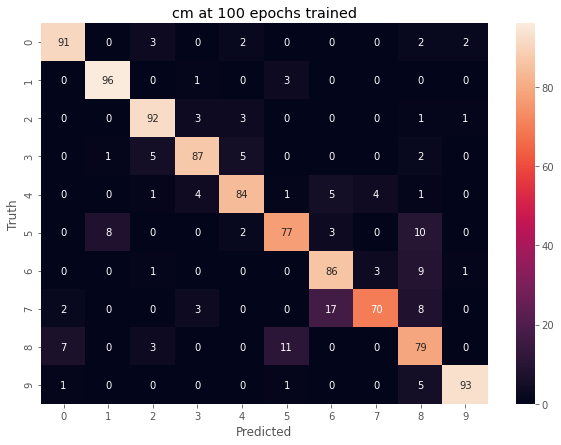

In [ ]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.title('cm at 100 epochs trained')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
!nvidia-smi

Sun Sep 12 16:25:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    58W / 149W |   6009MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Load Model

In [8]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/drive/MyDrive/sattriya01.h5')

# Show the model architecture
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                           

#Evaluation

In [19]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [21]:
y_pred=new_model.predict(x_test)

1
0


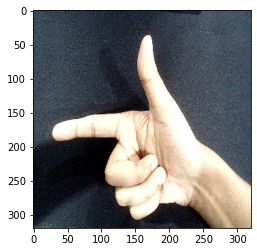

In [96]:
img_no = 998
plt.imshow(array_to_img(x_test[img_no]))
print(np.argmax(y_pred[img_no]))
print(y_test[img_no])

In [82]:
y_classes = [np.argmax(i) for i in y_pred]
print(y_classes)

[8, 6, 6, 3, 1, 5, 3, 1, 7, 7, 8, 7, 4, 3, 9, 8, 1, 6, 3, 1, 6, 2, 5, 5, 8, 1, 8, 1, 3, 5, 3, 5, 9, 7, 5, 5, 9, 5, 8, 3, 5, 3, 1, 1, 3, 4, 5, 3, 8, 9, 8, 1, 3, 8, 5, 8, 2, 5, 8, 8, 4, 5, 6, 6, 9, 3, 1, 8, 4, 1, 8, 6, 7, 1, 6, 3, 1, 4, 1, 7, 4, 8, 5, 8, 1, 4, 1, 3, 5, 1, 1, 1, 4, 1, 2, 5, 9, 2, 9, 4, 5, 5, 9, 4, 9, 3, 3, 8, 1, 4, 7, 1, 1, 5, 3, 1, 3, 5, 1, 6, 2, 1, 2, 5, 7, 8, 7, 5, 5, 1, 1, 5, 3, 1, 8, 5, 3, 8, 1, 4, 1, 9, 8, 0, 4, 2, 9, 3, 3, 8, 1, 5, 2, 4, 5, 5, 1, 1, 4, 3, 5, 5, 0, 7, 7, 7, 1, 7, 2, 9, 4, 1, 8, 9, 8, 9, 8, 3, 4, 7, 8, 7, 8, 8, 1, 7, 6, 3, 1, 7, 8, 4, 8, 8, 2, 2, 1, 1, 5, 8, 6, 1, 6, 1, 4, 8, 1, 1, 9, 1, 4, 6, 7, 8, 8, 2, 1, 3, 5, 8, 2, 4, 6, 2, 1, 3, 7, 8, 4, 4, 9, 4, 9, 1, 2, 0, 2, 6, 9, 4, 2, 3, 3, 9, 4, 6, 1, 1, 1, 5, 8, 9, 1, 5, 8, 5, 1, 9, 9, 4, 1, 1, 4, 5, 4, 7, 9, 7, 1, 9, 8, 7, 5, 1, 2, 7, 2, 9, 7, 1, 1, 5, 8, 9, 9, 1, 8, 3, 3, 3, 2, 7, 6, 9, 7, 6, 8, 1, 1, 7, 5, 2, 7, 9, 5, 2, 1, 9, 0, 4, 0, 7, 9, 8, 6, 1, 3, 8, 6, 8, 2, 7, 6, 6, 9, 5, 4, 3, 5, 6, 8, 3, 9, 

In [67]:
y_classes[:5]

[8, 6, 6, 3, 1]

In [68]:
y_test[:5]

array([8, 6, 0, 1, 1])

In [69]:
print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.09      0.16       100
           1       0.44      0.81      0.57       100
           2       0.73      0.61      0.67       100
           3       0.66      0.68      0.67       100
           4       0.81      0.86      0.83       100
           5       0.68      0.76      0.72       100
           6       0.66      0.61      0.64       100
           7       0.75      0.83      0.79       100
           8       0.83      0.89      0.86       100
           9       0.92      0.82      0.87       100

    accuracy                           0.70      1000
   macro avg       0.71      0.70      0.68      1000
weighted avg       0.71      0.70      0.68      1000



Text(69.0, 0.5, 'Truth')

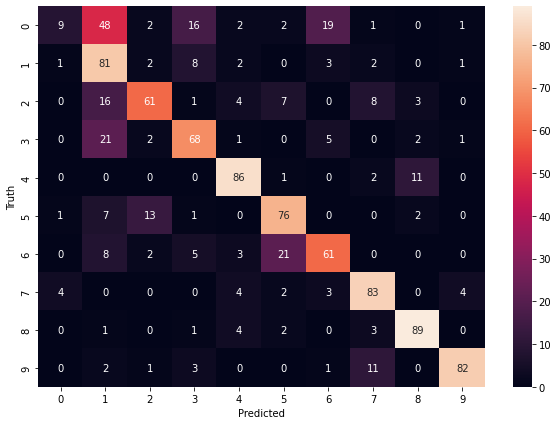

In [27]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print("F1-Score", f1_score(y_test, y_classes, average='macro'))

F1-Score 0.6772413389664973


#SAVE THE MODEL

In [32]:
model.save('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4/Data.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_DataAug_4/Data_weights.h5')

#Test Data

In [42]:
!mkdir Extracting_folder

In [57]:
path = "/content/Extracting_folder/Arya_test_2"
os.mkdir(path)

In [64]:
import shutil 
shutil.unpack_archive("/content/drive/MyDrive/Testset.zip", "/content/Extracting_folder/Arya_test_2")

In [33]:
!unzip "/content/drive/MyDrive/Testset.zip"

Archive:  /content/drive/MyDrive/Testset.zip
   creating: Testset/
 extracting: Testset/A-1.jpg         
 extracting: Testset/A-10.jpg        
 extracting: Testset/A-2.jpg         
 extracting: Testset/A-3.jpg         
 extracting: Testset/A-4.jpg         
 extracting: Testset/A-5.jpg         
 extracting: Testset/A-6.jpg         
 extracting: Testset/A-7.jpg         
 extracting: Testset/A-8.jpg         
 extracting: Testset/A-9.jpg         
 extracting: Testset/B-1.jpg         
 extracting: Testset/B-10.jpg        
 extracting: Testset/B-2.jpg         
 extracting: Testset/B-3.jpg         
 extracting: Testset/B-4.jpg         
 extracting: Testset/B-5.jpg         
 extracting: Testset/B-6.jpg         
 extracting: Testset/B-7.jpg         
 extracting: Testset/B-8.jpg         
 extracting: Testset/B-9.jpg         
 extracting: Testset/C-1.jpg         
 extracting: Testset/C-10.jpg        
 extracting: Testset/C-2.jpg         
 extracting: Testset/C-3.jpg         
 extracting: Testset/

In [34]:
path = '/content/Testset'

x_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
y_test = []
print('creating test data for recognition ( Only color images and respective labels)')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test[n]=img

    #labels
    heads, tails = os.path.split(newpath)
    y_test.append(tails[0])
    n+=1

creating test data for recognition ( Only color images and respective labels)


100%|██████████| 100/100 [00:00<00:00, 212.22it/s]


In [35]:
y_test

['D',
 'B',
 'H',
 'A',
 'J',
 'G',
 'I',
 'B',
 'I',
 'G',
 'F',
 'A',
 'D',
 'J',
 'G',
 'H',
 'B',
 'I',
 'A',
 'I',
 'E',
 'C',
 'D',
 'B',
 'B',
 'F',
 'F',
 'E',
 'J',
 'A',
 'I',
 'H',
 'J',
 'G',
 'F',
 'E',
 'C',
 'C',
 'I',
 'E',
 'A',
 'I',
 'A',
 'I',
 'D',
 'E',
 'C',
 'A',
 'E',
 'J',
 'D',
 'C',
 'J',
 'C',
 'J',
 'F',
 'I',
 'B',
 'F',
 'A',
 'F',
 'H',
 'F',
 'B',
 'B',
 'B',
 'C',
 'G',
 'H',
 'D',
 'H',
 'J',
 'E',
 'D',
 'J',
 'G',
 'C',
 'F',
 'H',
 'E',
 'D',
 'C',
 'F',
 'H',
 'G',
 'E',
 'G',
 'G',
 'A',
 'D',
 'C',
 'A',
 'I',
 'J',
 'G',
 'H',
 'E',
 'H',
 'B',
 'D']

In [36]:
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(y_test)

In [37]:
y_test

array([3, 1, 7, 0, 9, 6, 8, 1, 8, 6, 5, 0, 3, 9, 6, 7, 1, 8, 0, 8, 4, 2,
       3, 1, 1, 5, 5, 4, 9, 0, 8, 7, 9, 6, 5, 4, 2, 2, 8, 4, 0, 8, 0, 8,
       3, 4, 2, 0, 4, 9, 3, 2, 9, 2, 9, 5, 8, 1, 5, 0, 5, 7, 5, 1, 1, 1,
       2, 6, 7, 3, 7, 9, 4, 3, 9, 6, 2, 5, 7, 4, 3, 2, 5, 7, 6, 4, 6, 6,
       0, 3, 2, 0, 8, 9, 6, 7, 4, 7, 1, 3])

In [38]:
print(x_test.shape)
print(y_test.shape)

(100, 320, 320, 3)
(100,)


In [39]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [49]:
#    ######evaluate#####
checkpoint_path_recog = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/FHGR_NoData/Data_weights.h5"
model.load_weights(checkpoint_path_recog)

In [50]:
y_pred=model.predict(x_test)

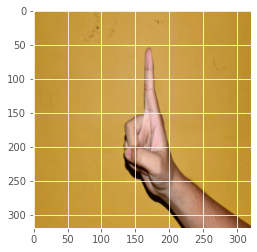

In [51]:
plt.imshow(array_to_img(x_test[5]))

In [52]:
y_classes = [np.argmax(i) for i in y_pred]

In [53]:
y_classes[:5]

[3, 1, 7, 0, 9]

In [54]:
y_test[:5]

array([3, 1, 7, 0, 9])

In [55]:
print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       1.00      0.90      0.95        10
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        10
           5       0.91      1.00      0.95        10
           6       0.83      1.00      0.91        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      0.80      0.89        10

    accuracy                           0.95       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.95      0.95       100



Text(69.0, 0.5, 'Truth')

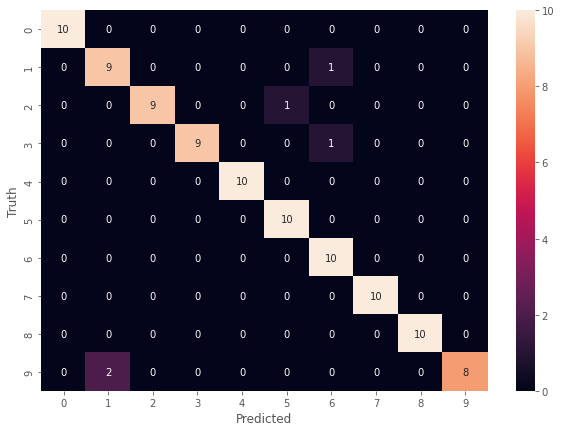

In [56]:
cm = confusion_matrix(y_test, y_classes)
#Visualising Confusion Matrix using seaborn
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [57]:
print("F1-Score", f1_score(y_test, y_classes, average='macro'))

F1-Score 0.9502240449608872
